# Ejemplo implementación Dropout en una red neuronal

El código a continuación presenta un ejemplo de implementación de la técnica de regularización Dropout para una red neuronal aplicado al conjunto de datos MNIST. Para mayor comprensión en las funciones utilizadas se recomienda la [documentación de Pytorch](https://pytorch.org/docs/stable/index.html).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
import random
from distutils.version import LooseVersion as Version
import time

In [2]:
##########################
### CONFIGURACIONES INICIALES
##########################

SEMILLA_ALEATORIA = 123
TAMAÑO_LOTE = 256
NUM_CAPA1 = 75
NUM_CAPA2 = 45
NUM_EPOCAS = 50
DISPOSITIVO = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Vamos a definir un par de funciones para el desarrollo del ejemplo, la función ``` set_all_seeds()``` establece las distintas funciones aleatorias en las librerías para que todas tengan el mismo parámetro. La función ```set_deterministic()``` ajusta las funciones de la librería torch para que sean deterministas si es posible, es decir que se obtenga el mismo resultado siempre que se ingresen los mismos datos.



In [3]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)

La función ```get_dataloaders_mnist()``` se encargará de crear los conjuntos de datos de entrenamiento, prueba y validación utilizando como datos el conjunto MNIST y haciendo las configuraciones adecuadas acorde a los parámetros iniciales del tamaño de los lotes y porcentajes. Esta función presenta un nuevo parámetro ```num_workers``` que se utilizan para controlar la carga de datos al equipo. Para mayor información sobre este parámetro se recomienda el [siguiente enlace](https://www.geeksforgeeks.org/how-the-number-of-workers-parameter-in-pytorch-dataloader-actually-works/)



In [4]:
def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None,
                          test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader

In [5]:
##########################
### MNIST DATASET
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=TAMAÑO_LOTE,
    validation_fraction=0.1)

# Checking the dataset
for imagenes, etiquetas in train_loader:
    print('Dimensiones de las imágenes:', imagenes.shape)
    print('Dimensiones de las etiquetas:', etiquetas.shape)
    print('Etiquetas de 10 imágenes distintas:', etiquetas[:10])
    break

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.23MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.80MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dimensiones de las imágenes: torch.Size([256, 1, 28, 28])
Dimensiones de las etiquetas: torch.Size([256])
Etiquetas de 10 imágenes distintas: tensor([8, 6, 6, 1, 1, 0, 2, 6, 7, 8])


## Modelo

La construcción del modelo en pytorch sigue una estructura similar a como se ha construido en anteriores ejemplos exceptuando una nueva función llamada ```torch.nn.Dropout()```, lo que hace esta función es aplicar el algoritmo de dropout durante el proceso de entrenamiento. Dentro de los paréntesis podemos ingresar el parámetro de la probabilidad que deseemos para el algoritmo, teniendo por defecto una probabilidad de 0.5

In [6]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_caracteristicas, num_clases, drop_proba,
                 num_oculta_1, num_oculta_2):
        super().__init__()

        self.my_network = torch.nn.Sequential(
            # PRIMERA CAPA OCULTA
            torch.nn.Flatten(),
            torch.nn.Linear(num_caracteristicas, num_oculta_1),
            torch.nn.ReLU(),   # FUNCIÓN DE ACTIVACIÓN ReLU
            torch.nn.Dropout(drop_proba),  # DROPOUT EN LA PRIMER CAPA
            # SEGUNDA CAPA OCULTA
            torch.nn.Linear(num_oculta_1, num_oculta_2),
            torch.nn.ReLU(),
            torch.nn.Dropout(drop_proba), # DROPOUT EN LA SEGUNDA CAPA
            # CAPA DE SALIDA
            torch.nn.Linear(num_oculta_2, num_clases)
        )

    def forward(self, x):
        predicciones = self.my_network(x)
        return predicciones

Definimos una función para calcular la exactitud del modelo

In [7]:
def compute_accuracy(modelo, data_loader, dispositivo):

    with torch.no_grad():

        correct_pred, num_ejemplos = 0, 0

        for i, (caracteristicas, objetivos) in enumerate(data_loader):

            caracteristicas = caracteristicas.to(dispositivo)
            objetivos = objetivos.float().to(dispositivo)

            predicciones = modelo(caracteristicas)
            _, etiquetas_predichas = torch.max(predicciones, 1)

            num_ejemplos += objetivos.size(0)
            correct_pred += (etiquetas_predichas == objetivos).sum()
    return correct_pred.float()/num_ejemplos * 100

## Función para el entrenamiento del modelo

In [8]:
def train_model(modelo, num_epocas, train_loader,
                valid_loader, test_loader, optimizador, dispositivo):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], [] # Listas para almacenar los resultados de la función error y exactitud
    for epoca in range(num_epocas):

# Nota: Es necesario indicar con la función modelo.train() el comienzo del entrenamiento del modelo pues solo en este estado
#       se activa el dropout en la red neuronal.
        modelo.train()
        for lote_idx, (caracteristica, objetivo) in enumerate(train_loader):

            caracteristica = caracteristica.to(dispositivo)
            objetivo = objetivo.to(dispositivo)

            # ## FORWARD AND BACK PROP
            predicciones = modelo(caracteristica)
            error = torch.nn.functional.cross_entropy(predicciones, objetivo)
            optimizador.zero_grad()

            error.backward()

            # ## SE ACTUALIZAN LOS PARÁMETROS DEL MODELO (PESOS, BIAS) UTILIZANDO PROPAGACIÓN HACIA ATRÁS
            optimizador.step()

            # ## REGISTRO
            minibatch_loss_list.append(error.item())
            if not lote_idx % 50:
                print(f'Epoca: {epoca+1:03d}/{num_epocas:03d} '
                      f'| Lote {lote_idx:04d}/{len(train_loader):04d} '
                      f'| Error: {error:.4f}')

# Nota: Es necesario indicar con la función model.eval() el comienzo de la fase de evaluación del modelo, esto con el fin de que no se active
#       el dropout como se hizo en la fase de entrenamiento.
        modelo.eval()
        with torch.no_grad():
            train_acc = compute_accuracy(modelo, train_loader, dispositivo=dispositivo)
            valid_acc = compute_accuracy(modelo, valid_loader, dispositivo=dispositivo)
            print(f'Epoca: {epoca+1:03d}/{num_epocas:03d} '
                  f'| Exactitud del entrenamiento: {train_acc :.2f}% '
                  f'| Exactitud de la validación: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

        transcurrido = (time.time() - start_time)/60
        print(f'Tiempo transcurrido: {transcurrido:.2f} min')

    transcurrido = (time.time() - start_time)/60
    print(f'Tiempo total transcurrido: {transcurrido:.2f} min')

    test_acc = compute_accuracy(modelo, test_loader, dispositivo=dispositivo)
    print(f'Exactitud de la prueba: {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list

## Funciones para visualizar el error y la exactitud de los modelos

In [9]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Error por lotes')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Error')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Promedio')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epocas')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Entrenamiento')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validación')

    plt.xlabel('Epoca')
    plt.ylabel('Exactitud')
    plt.legend()

    plt.tight_layout()



def show_examples(model, data_loader):

    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhw_img[idx], cmap='binary')
        ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
        ax.axison = False

    plt.tight_layout()
    plt.show()

## Creación de un modelo con probabilidad de Dropout 0%

Epoca: 001/050 | Lote 0000/0210 | Error: 2.3093
Epoca: 001/050 | Lote 0050/0210 | Error: 1.8443
Epoca: 001/050 | Lote 0100/0210 | Error: 0.7622
Epoca: 001/050 | Lote 0150/0210 | Error: 0.6539
Epoca: 001/050 | Lote 0200/0210 | Error: 0.5036
Epoca: 001/050 | Exactitud del entrenamiento: 86.56% | Exactitud de la validación: 89.12%
Tiempo transcurrido: 0.29 min
Epoca: 002/050 | Lote 0000/0210 | Error: 0.4685
Epoca: 002/050 | Lote 0050/0210 | Error: 0.4341
Epoca: 002/050 | Lote 0100/0210 | Error: 0.3330
Epoca: 002/050 | Lote 0150/0210 | Error: 0.3330
Epoca: 002/050 | Lote 0200/0210 | Error: 0.3604
Epoca: 002/050 | Exactitud del entrenamiento: 90.23% | Exactitud de la validación: 92.15%
Tiempo transcurrido: 0.56 min
Epoca: 003/050 | Lote 0000/0210 | Error: 0.2568
Epoca: 003/050 | Lote 0050/0210 | Error: 0.2746
Epoca: 003/050 | Lote 0100/0210 | Error: 0.2673
Epoca: 003/050 | Lote 0150/0210 | Error: 0.2206
Epoca: 003/050 | Lote 0200/0210 | Error: 0.3525
Epoca: 003/050 | Exactitud del entrenami

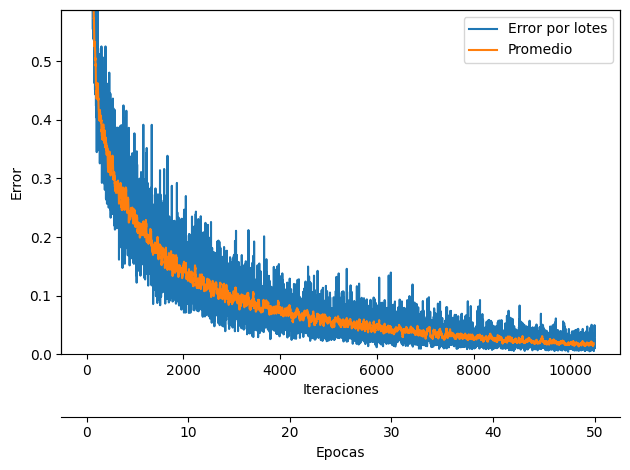

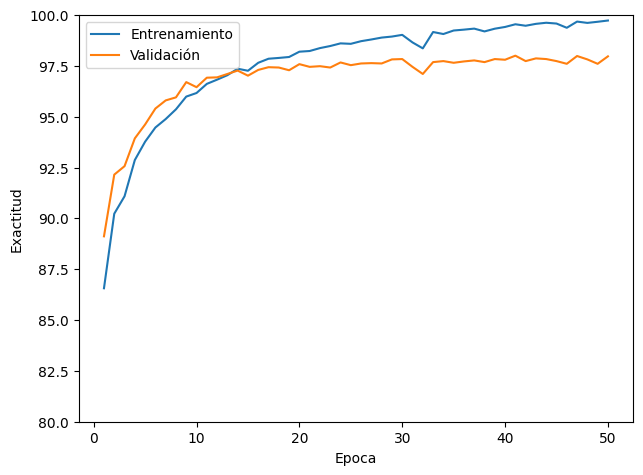

In [10]:
torch.manual_seed(SEMILLA_ALEATORIA)
modelo_dropout0 = MultilayerPerceptron(num_caracteristicas=28*28,
                             num_oculta_1=NUM_CAPA1,
                             num_oculta_2=NUM_CAPA2,
                             drop_proba=0.0,
                             num_clases=10)
modelo_dropout0 = modelo_dropout0.to(DISPOSITIVO)

OPTIMIZADOR = torch.optim.SGD(modelo_dropout0.parameters(), lr=0.1)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    modelo=modelo_dropout0,
    num_epocas=NUM_EPOCAS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizador=OPTIMIZADOR,
    dispositivo=DISPOSITIVO)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCAS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

## Creación de un modelo con probabilidad de Dropout 50%

Epoca: 001/050 | Lote 0000/0210 | Error: 2.3132
Epoca: 001/050 | Lote 0050/0210 | Error: 2.0828
Epoca: 001/050 | Lote 0100/0210 | Error: 1.5250
Epoca: 001/050 | Lote 0150/0210 | Error: 1.2467
Epoca: 001/050 | Lote 0200/0210 | Error: 1.0186
Epoca: 001/050 | Exactitud del entrenamiento: 82.36% | Exactitud de la validación: 85.47%
Tiempo transcurrido: 0.27 min
Epoca: 002/050 | Lote 0000/0210 | Error: 0.9355
Epoca: 002/050 | Lote 0050/0210 | Error: 0.9608
Epoca: 002/050 | Lote 0100/0210 | Error: 0.7889
Epoca: 002/050 | Lote 0150/0210 | Error: 0.7475
Epoca: 002/050 | Lote 0200/0210 | Error: 0.6573
Epoca: 002/050 | Exactitud del entrenamiento: 88.25% | Exactitud de la validación: 90.50%
Tiempo transcurrido: 0.54 min
Epoca: 003/050 | Lote 0000/0210 | Error: 0.7553
Epoca: 003/050 | Lote 0050/0210 | Error: 0.6540
Epoca: 003/050 | Lote 0100/0210 | Error: 0.5696
Epoca: 003/050 | Lote 0150/0210 | Error: 0.7052
Epoca: 003/050 | Lote 0200/0210 | Error: 0.5454
Epoca: 003/050 | Exactitud del entrenami

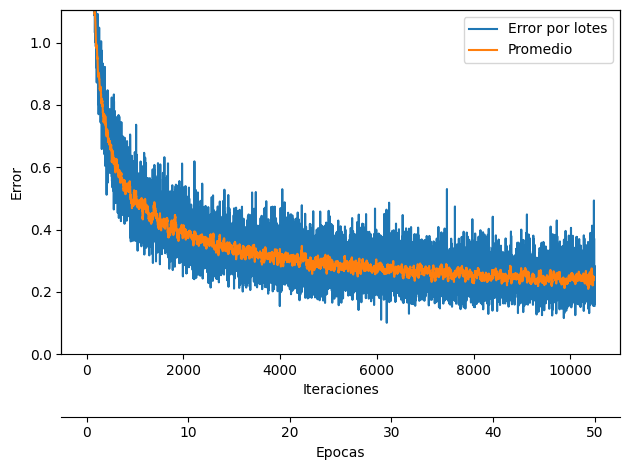

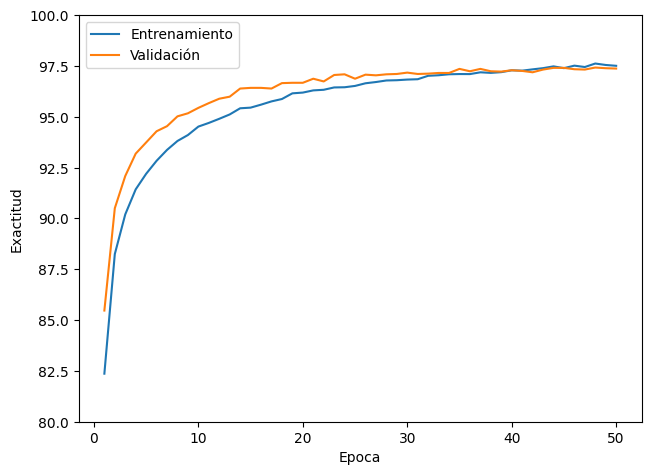

In [11]:
torch.manual_seed(SEMILLA_ALEATORIA)
modelo_dropout0 = MultilayerPerceptron(num_caracteristicas=28*28,
                             num_oculta_1=NUM_CAPA1,
                             num_oculta_2=NUM_CAPA2,
                             drop_proba=0.5,
                             num_clases=10)
modelo_dropout0 = modelo_dropout0.to(DISPOSITIVO)

OPTIMIZADOR = torch.optim.SGD(modelo_dropout0.parameters(), lr=0.1)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    modelo=modelo_dropout0,
    num_epocas=NUM_EPOCAS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizador=OPTIMIZADOR,
    dispositivo=DISPOSITIVO)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCAS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

# Ejemplo Normalización por lotes en una red neuronal

## Modelo

La construcción del modelo en pytorch sigue una estructura similar a como se ha construido en anteriores ejemplos exceptuando una nueva función llamada ```torch.nn.BatchNorm1d()```, lo que hace esta función es aplicar el algoritmo de normalización por lotes durante el proceso de entrenamiento. Dentro de los paréntesis debemos ingresar el número de caracteristicas que tiene la capa.

In [12]:
class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_caracteristicas, num_clases,
                 num_oculta_1, num_oculta_2):
        super().__init__()

        self.my_network = torch.nn.Sequential(
            # PRIMERA CAPA OCULTA
            torch.nn.Flatten(),
            torch.nn.Linear(num_caracteristicas, num_oculta_1, bias=False),
            torch.nn.BatchNorm1d(num_oculta_1),  # NORMALIZACIÓN POR LOTES
            torch.nn.ReLU(),
            # SEGUNDA CAPA OCULTA
            torch.nn.Linear(num_oculta_1, num_oculta_2, bias=False),
            torch.nn.BatchNorm1d(num_oculta_2), # NORMALIZACIÓN POR LOTES
            torch.nn.ReLU(),
            # CAPA DE SALIDA
            torch.nn.Linear(num_oculta_2, num_clases)
        )

    def forward(self, x):
        predicciones = self.my_network(x)
        return predicciones

Epoca: 001/050 | Lote 0000/0210 | Error: 2.3559
Epoca: 001/050 | Lote 0050/0210 | Error: 0.4216
Epoca: 001/050 | Lote 0100/0210 | Error: 0.3420
Epoca: 001/050 | Lote 0150/0210 | Error: 0.2311
Epoca: 001/050 | Lote 0200/0210 | Error: 0.2121
Epoca: 001/050 | Exactitud del entrenamiento: 95.71% | Exactitud de la validación: 96.55%
Tiempo transcurrido: 0.29 min
Epoca: 002/050 | Lote 0000/0210 | Error: 0.1470
Epoca: 002/050 | Lote 0050/0210 | Error: 0.2062
Epoca: 002/050 | Lote 0100/0210 | Error: 0.1260
Epoca: 002/050 | Lote 0150/0210 | Error: 0.1255
Epoca: 002/050 | Lote 0200/0210 | Error: 0.1484
Epoca: 002/050 | Exactitud del entrenamiento: 97.42% | Exactitud de la validación: 97.32%
Tiempo transcurrido: 0.56 min
Epoca: 003/050 | Lote 0000/0210 | Error: 0.1065
Epoca: 003/050 | Lote 0050/0210 | Error: 0.0846
Epoca: 003/050 | Lote 0100/0210 | Error: 0.0887
Epoca: 003/050 | Lote 0150/0210 | Error: 0.0743
Epoca: 003/050 | Lote 0200/0210 | Error: 0.1047
Epoca: 003/050 | Exactitud del entrenami

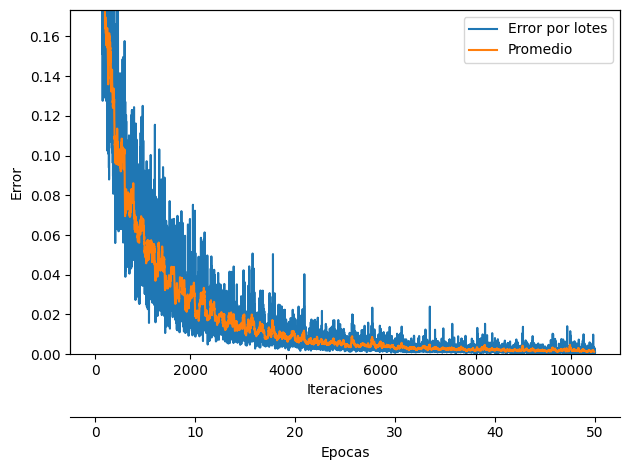

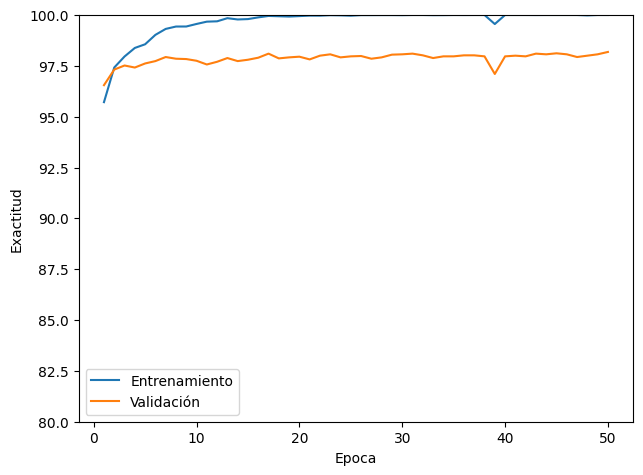

In [13]:
torch.manual_seed(SEMILLA_ALEATORIA)
modelo_normalizacionL = MultilayerPerceptron(num_caracteristicas=28*28,
                             num_oculta_1=NUM_CAPA1,
                             num_oculta_2=NUM_CAPA2,
                             num_clases=10)
model = modelo_normalizacionL.to(DISPOSITIVO)

optimizador = torch.optim.SGD(model.parameters(), lr=0.1)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    modelo=modelo_normalizacionL,
    num_epocas=NUM_EPOCAS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizador=optimizador,
    dispositivo=DISPOSITIVO)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCAS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()